# Import packages and set up config


In [ ]:
import requests
import pandas
from dateutil import parser
host = 'http://18.188.56.207:9200/'
requests.get(host + '_cat/indices/enron').content

import nltk
import pandas as pd
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA
nltk.download('vader_lexicon')

import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import json
import time

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


# Define Functions for project

In [ ]:
def elasticsearch_results_to_df(results):
    '''
    A function that will take the results of a requests.get 
    call to Elasticsearch and return a pandas.DataFrame object 
    with the results 
    '''
    hits = results.json()['hits']['hits']
    data = pandas.DataFrame([i['_source'] for i in hits], index = [i['_id'] for i in hits])
    data['date'] = data['date'].apply(parser.parse)
    return(data)

def print_df_row(row):
    '''
    A function that will take a row of the data frame and print it out
    '''
    print('____________________')
    print('RE: %s' % row.get('subject',''))
    print('At: %s' % row.get('date',''))
    print('From: %s' % row.get('sender',''))
    print('To: %s' % row.get('recipients',''))
    print('CC: %s' % row.get('cc',''))
    print('BCC: %s' % row.get('bcc',''))
    print('Body:\n%s' % row.get('text',''))
    print('____________________')

def sentiment_analysis(df):
  sia = SIA()
  results = [sia.polarity_scores(line) for line in df.text]
  df = df.reset_index()
      
  scores_df = pd.DataFrame.from_records(results)
  df_senti = scores_df.join(df, rsuffix="_right")
  df_senti = df_senti.sort_values(by=['neg'], ascending=False)
  return df_senti

def plot_wordcloud(wordcloud, w, h):
    plt.figure(figsize=(w, h))
    plt.imshow(wordcloud) 
    plt.axis("off")


# Part 1 - Explore the database for 401K related emails

### Top 10k emails are extracted

In [ ]:
# Query For a full text match in the "text" field
# Uses the "match" query: https://www.elastic.co/guide/en/elasticsearch/reference/current/query-dsl-match-query.html
doc = {
    "query": {
        "match" : {
            "text" : "401k"
        } 
    },
    "from" : 0, # Starting message to return. 
    "size" : 10000, # Return this many messages. Can't be more than 10,000
}
r=requests.get(host + 'enron/_search',
               data=json.dumps(doc), headers={'Content-Type':'application/json'})
r.raise_for_status()
df = elasticsearch_results_to_df(r)
print("Returned %s messages" % df.shape[0])


Returned 140 messages


# Explore dataset

In [ ]:
print_df_row(df.iloc[40])

____________________
RE: Anniversary Luncheon
At: 2001-11-14 15:40:56+00:00
From: rebecca.longoria@enron.com
To: kenneth.lay@enron.com
CC: nan
BCC: nan
Body:
Dear Mr. Lay,

I am one of many long time employees who has lost my life's savings and my kid's college fund.

Today I am receiving my 15 Years of Service Award and having my Anniversary luncheon.  Would you like to attend?  My Department would appreciate a candid picture of how this could have happened to such a great company.  I have gone through tough times and many good times with Northern Natural Gas, InterNorth and Enron.  I was always so proud to be a part of this company. 

Should I have seen this coming?  I was just another sheep following and believing everything our leaders, Skilling, said regarding the probability of Enron's stock splitting.  I didn't play the market but looked at my 401K stock purchases as long term retirement and continued to put money into the 401K even when we (my family) were struggling to do so.


# Run Sentiment analysis on the extracted dataset

In [ ]:
df_senti = sentiment_analysis(df)
df_senti.head()

,neg,neu,pos,compound,index,date,text,sender,recipients,subject,cc,bcc
22,0.141,0.775,0.084,-0.5330,120238,2001-11-09 16:16:31+00:00,How can you sell Enron for $9.50 per share? W...,steven_fallt@pgn.com,kenneth.lay@enron.com,How can you sell Enron for $9.50 per share? W...,NaN,NaN
7,0.115,0.885,0.000,-0.2960,155869,2001-11-30 18:21:31+00:00,I just thought about you 401k. Should you sto...,jennsreit@houston.rr.com,jreitme@enron.com,401k,NaN,NaN
134,0.111,0.781,0.109,-0.9991,41475,2001-10-01 13:29:51+00:00,"I am pleased to send you the October 1, 2001 w...",jordan.w.cowman@bakernet.com,cowman@enron.com jordan.w.cowman@bakernet.com,"Jordan Cowman- October 1, 2001 Baker & McKenzi...",cowman@enron.com jordan.w.cowman@bakernet.com,cowman@enron.com jordan.w.cowman@bakernet.com
21,0.103,0.841,0.055,-0.1280,90278,2001-11-13 18:18:41+00:00,"sorry, no\n\n -----Original Message-----\nFrom...",jason.wolfe@enron.com,beth.cherry@enform.com,RE:,NaN,NaN
9,0.100,0.900,0.000,-0.2500,55350,2000-10-17 15:52:00+00:00,"Jennifer,\n\nI am anxious to get set up on the...",chris.dorland@enron.com,jennifer.milligan@enron.com,401K Plan,NaN,NaN


# Buld a word cloud to visualise keywords from the top 10 negative emails

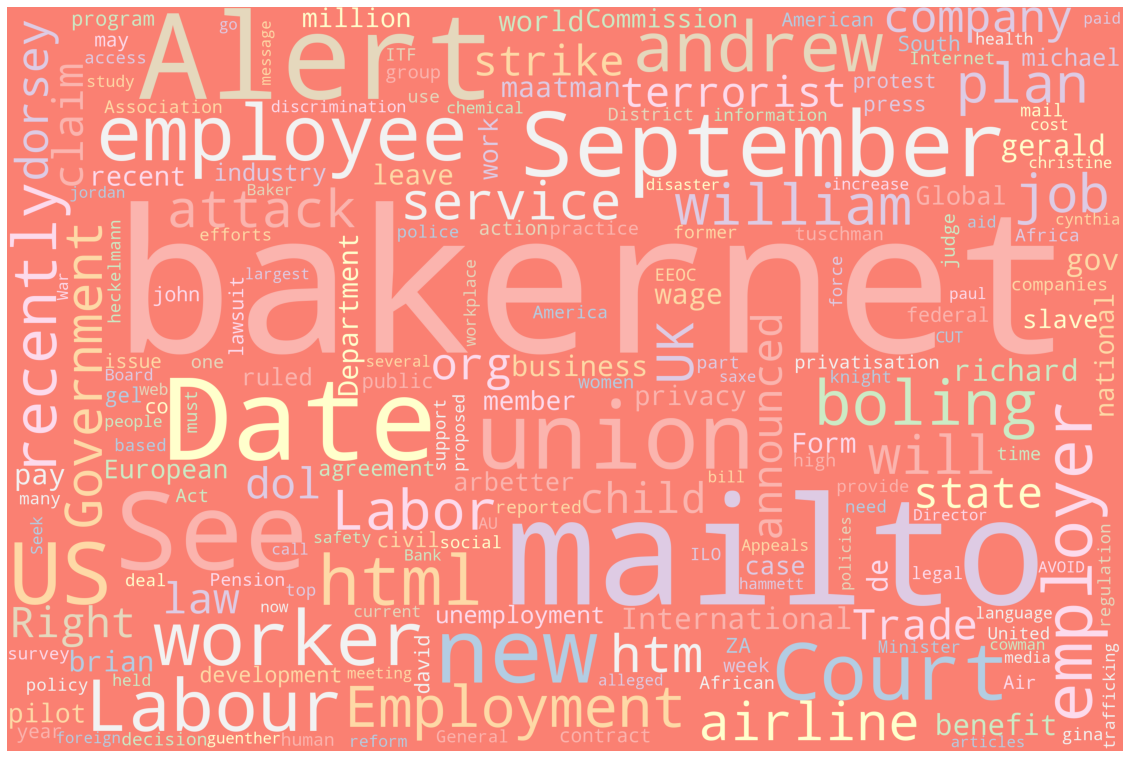

In [ ]:
df_filtered = df_senti[df_senti['neg']>=0.1].head(10)
wordcloud = WordCloud(width= 3000, height = 2000, random_state=1, background_color='salmon', colormap='Pastel1', collocations=False, stopwords = STOPWORDS).generate(' '.join(df_filtered.text))
plot_wordcloud(wordcloud, 20, 15)

# Add more stopwords

In [ ]:
STOPWORDS.add("Date")
STOPWORDS.add("mailto")

# Search query using the set of pre-selected keywords
"401k" and:
*   Fraud
*   Bankruptcy
*   College fund
*   Retirement
*   Struggle
*   Life’s saving
*   Stock
*   Ethic
*   Share

In [ ]:
doc = {
    "query": {
        "multi_match" : {
            "fields": ["text" ],
            "query" : "401k AND ((fraud)" +
            " OR (college fund)" +
            " or (retirement)" +
            " or (struggle)" +
            " or (life's saving)" +
            " or (stock)" +
            " or (ethic)" + 
            " or (share))" 
        }
    },
    "from" : 0, # Starting message to return. 
    "size" : 10000, # Return this many messages. Can't be more than 10,000
}
r=requests.get(host + 'enron/_search', data=json.dumps(doc), headers={'Content-Type':'application/json'})
r.raise_for_status()
print("Found %s messages matching the query" % r.json()['hits']['total']['value'])
df = elasticsearch_results_to_df(r)

Found 10000 messages matching the query


# Sentiment analysis + Word Cloud

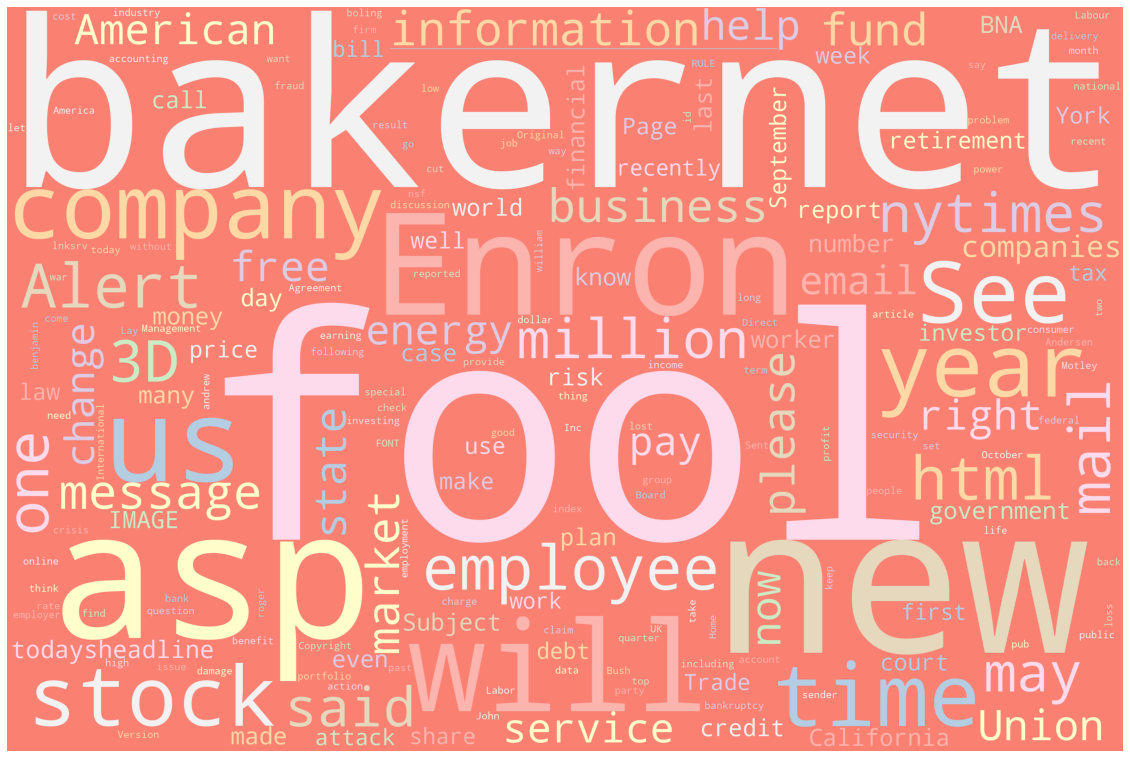

In [ ]:
df_senti = sentiment_analysis(df)
# df.head(10)
df_filtered = df_senti[df_senti['neg']>=0.1]
wordcloud = WordCloud(width= 3000, height = 2000, random_state=1, background_color='salmon', colormap='Pastel1', collocations=False, stopwords = STOPWORDS).generate(' '.join(df_filtered.text))
plot_wordcloud(wordcloud, 20, 15)

In [ ]:
doc = {
    "query": {
        "multi_match" : {
            "fields": ["text" ],
            "query" : "401k AND (stock or Stock)" + 
            " AND (college fund)" +
            " or (retirement)" +
            " or (struggle)" +
            " or (ethic)" + 
            " or (life's saving)"
            " or (share))" 
        }
    },
    "from" : 0, # Starting message to return. 
    "size" : 10000, # Return this many messages. Can't be more than 10,000
}
r=requests.get(host + 'enron/_search', data=json.dumps(doc), headers={'Content-Type':'application/json'})
r.raise_for_status()
print("Found %s messages matching the query" % r.json()['hits']['total']['value'])
df = elasticsearch_results_to_df(r)
df_senti = sentiment_analysis(df)

Found 10000 messages matching the query


In [ ]:
df_new = df_senti[df_senti["text"].str.contains("tough times") & df_senti["text"].str.contains("struggling")]
print_df_row(df_new.iloc[1])

____________________
RE: Anniversary Luncheon
At: 2001-11-14 15:40:56+00:00
From: rebecca.longoria@enron.com
To: kenneth.lay@enron.com
CC: nan
BCC: nan
Body:
Dear Mr. Lay,

I am one of many long time employees who has lost my life's savings and my kid's college fund.

Today I am receiving my 15 Years of Service Award and having my Anniversary luncheon.  Would you like to attend?  My Department would appreciate a candid picture of how this could have happened to such a great company.  I have gone through tough times and many good times with Northern Natural Gas, InterNorth and Enron.  I was always so proud to be a part of this company. 

Should I have seen this coming?  I was just another sheep following and believing everything our leaders, Skilling, said regarding the probability of Enron's stock splitting.  I didn't play the market but looked at my 401K stock purchases as long term retirement and continued to put money into the 401K even when we (my family) were struggling to do so.


In [ ]:
df_new = df_senti[df_senti["text"].str.contains("destroyed") & df_senti["text"].str.contains("miserable")]
print_df_row(df_new.iloc[3])

____________________
RE: 
At: 2001-12-12 23:52:29+00:00
From: nshaw@usenergyservices.com
To: kenneth.lay@enron.com
CC: nan
BCC: nan
Body:
Dear Ken,

Several weeks ago I sent you an email regarding the amount of money you
owe me as a result of Enron's demise.  Thus far you have not responded.

Based on today's closing stock price for Enron, the current amount you
owe me and my family is now $1,171,968.00 which must be replaced in my
401K . This money you so callously destroyed was intended to pay for my
children's education and provide a retirement fund for my wife and me.
I worked for Enron for almost 19 years and I earned every bit of this
retirement.  Have you ever lived in Midland Texas where the dust blows
so thick you cannot see or breathe?  I experienced these conditions
often when I lived there while I worked for Enron.  Have you ever lived
in Minnesota and cleared snow drifts 6 feet high when the wind chill was
100 degrees below zero so you could get your children to school?  I

In [ ]:
df_new = df_senti[df_senti["text"].str.contains("greed") & df_senti["text"].str.contains("power")]
print_df_row(df_new.iloc[17])

____________________
RE: GREED
At: 2001-11-29 15:03:29+00:00
From: cannon_craig@yahoo.com
To: kenneth.lay@enron.com
CC: nan
BCC: nan
Body:
Dr. Lay,
What a joke ... Do realize how lives you and your
board of directors have ruined >>>> all because of
greed and power .... I looked up to for a while
building a great company nice place to work  but then
greed got in your way ... Lets hear again why Skilling
quit ?? because of family ... BS. Over the past ten
years i have worked at
Enron as a computer contractor in payroll and i saw
the outlandish executive bonuses and money to the
islands.  I hope you get justly fined and sent to
prison for the fraud you have committed. The few
shares
of enron i have left are not worth the paper they are
printed on.....i also saw all the stock options you
and the board have excersied over thats few years 100s
of million dollars what a shame ...
  When you opted to replace the oracle Payroll with
SAP I new you were loosing your mind ....

all the great peopl

In [ ]:
df_new = df_senti[df_senti["text"].str.contains("crisis") & df_senti["text"].str.contains("retirement")]
print_df_row(df_new.iloc[0])

____________________
RE: Demand Ken Lay Donate Proceeds from Enron Stock Sales
At: 2002-01-30 17:45:08+00:00
From: imprintagency@earthlink.net
To: klay@enron.com
CC: nan
BCC: nan
Body:
Stephany Evans
imprintagency@earthlink.net

To Mr. Ken Lay,

I'm writing to urge you to donate the millions of dollars you
made from selling Enron stock before the company
declared bankruptcy to funds, such as Enron Employee
Transition Fund and REACH, that benefit the company's
employees, who lost their retirement savings, and provide
relief to low-income consumers in California, who can't
afford to pay their energy bills.  Enron and you made
millions out of the pocketbooks of California consumers
and from the efforts of your employees.

Indeed, while you netted well over a $100 million, many of
Enron's employees were financially devastated when the
company declared bankruptcy and their retirement plans
were wiped out.  And Enron made an astronomical profit
during the California energy crisis last year. 

In [ ]:
df_new = df_senti[df_senti["text"].str.contains("disappointed") & df_senti["text"].str.contains("fraud")]
print_df_row(df_new.iloc[19])

____________________
RE: A dissapointed stockholder
At: 2001-10-31 07:14:37+00:00
From: wjheilman@worldnet.att.net
To: kenneth.lay@enron.com
CC: nan
BCC: nan
Body:

I have been an Enron stockholder for several years  and I am very disappointed with the events of the last two weeks.  I find  the allegations of accounting irregularities incredible.  I would like to  know how closely the board had been monitoring the activities of the CFO and  whether it approved the partnerships that have led to the SEC investigation and  the dramatic decline in the company's stock price.  I would suggest that  the compensation of senior management may be too heavily weighted towards  bonuses (giving some the incentive to manipulate the numbers to increase their  bonuses) and not heavily weighted enough towards stock options.  I would  hope in the future the goals of the board and senior management will be aligned  with stockholders (increasing shareholder value).  While I know it is not  reason to have 